In [1]:
import os
import numpy as np
import pandas as pd
import json
import yaml
import pickle
import warnings
import logging
import gc
import random
import math
import re
import ast
from tqdm import tqdm
from typing import Optional
from datetime import datetime

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader, TensorDataset

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# --------------------------------------------------------- CONFIGURATIONS --------------------------------------------------------- #

In [3]:
# TARGET_COLUMN = "code_mixed_explanation"
# TEXT_INPUT_PATH = "../Data/Text/"
# ACOUSTIC_INPUT_PATH = "../Data/Audio/"
# VISUAL_INPUT_PATH = "../Data/Video/"

# MODEL_OUTPUT_DIR = check_and_create_directory("../models/MAF_TAV_BART/")
# RESULT_OUTPUT_DIR = check_and_create_directory("../results/MAF_TAV_BART/")

# LOWERCASE_UTTERANCES = False
# UNFOLDED_DIALOGUE = True

# if UNFOLDED_DIALOGUE:
#     SOURCE_COLUMN = "dialogue"
# else:
#     SOURCE_COLUMN_1 = "target"
#     SOURCE_COLUMN_2 = "context"

SOURCE_MAX_LEN = 480
TARGET_MAX_LEN = 50
MAX_UTTERANCES = 25

ACOUSTIC_DIM = 154
ACOUSTIC_MAX_LEN = 600

VISUAL_DIM = 2048
VISUAL_MAX_LEN = 96

BATCH_SIZE = 4
MAX_EPOCHS = 60

BASE_LEARNING_RATE = 5e-6
NEW_LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4

NUM_BEAMS = 5
EARLY_STOPPING = True
NO_REPEAT_NGRAM_SIZE = 3

EARLY_STOPPING_THRESHOLD = 5

In [4]:
# --------------------------------------------------------- MODEL --------------------------------------------------------- #

In [5]:
%%capture
!pip install transformers datasets evaluate
!pip install transformer-encoder

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.nn import CrossEntropyLoss, MSELoss

from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

from transformers.modeling_utils import PreTrainedModel, unwrap_model

from transformers import (
    BartTokenizerFast,
    AdamW
)

from transformers.models.bart.configuration_bart import BartConfig

from transformers.models.bart.modeling_bart import (
    BartPretrainedModel,
    BartDecoder,
    BartLearnedPositionalEmbedding,
    BartEncoderLayer,
    shift_tokens_right,
    _make_causal_mask,
    _expand_mask
)

from transformers.modeling_outputs import (
    BaseModelOutput,
    Seq2SeqLMOutput,
    Seq2SeqModelOutput
)

from transformer_encoder import TransformerEncoder

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# --------------------------------------------------------- Mulitmodal Context Aware Attention --------------------------------------------------------- #

In [9]:
class ContextAwareAttention(nn.Module):

    def __init__(self,
                 dim_model: int,
                 dim_context: int,
                 dropout_rate: Optional[float]=0.0):
        super(ContextAwareAttention, self).__init__()

        self.dim_model = dim_model
        self.dim_context = dim_context
        self.dropout_rate = dropout_rate
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.attention_layer = nn.MultiheadAttention(embed_dim=self.dim_model,
                                                     num_heads=1,
                                                     dropout=self.dropout_rate,
                                                     bias=True,
                                                     add_zero_attn=False,
                                                     batch_first=True,
                                                     device=self.device)


        self.u_k = nn.Linear(self.dim_context, self.dim_model, bias=False)
        self.w1_k = nn.Linear(self.dim_model, 1, bias=False)
        self.w2_k = nn.Linear(self.dim_model, 1, bias=False)

        self.u_v = nn.Linear(self.dim_context, self.dim_model, bias=False)
        self.w1_v = nn.Linear(self.dim_model, 1, bias=False)
        self.w2_v = nn.Linear(self.dim_model, 1, bias=False)

    def forward(self,
                q: torch.Tensor,
                k: torch.Tensor,
                v: torch.Tensor,
                context: Optional[torch.Tensor]=None):

        key_context = self.u_k(context)
        value_context = self.u_v(context)

        lambda_k = F.sigmoid(self.w1_k(k) + self.w2_k(key_context))
        lambda_v = F.sigmoid(self.w1_v(v) + self.w2_v(value_context))

        k_cap = (1 - lambda_k) * k + lambda_k * key_context
        v_cap = (1 - lambda_v) * v + lambda_v * value_context

        attention_output, _ = self.attention_layer(query=q,
                                                   key=k_cap,
                                                   value=v_cap)
        return attention_output

In [10]:
# --------------------------------------------------------- Modality Aware Fusion --------------------------------------------------------- #

In [11]:
class MAF(nn.Module):

    def __init__(self,
                 dim_model: int,
                 dropout_rate: int,
                 util_config: dict):
        super(MAF, self).__init__()
        self.dropout_rate = dropout_rate

        self.action_context_transform = nn.Linear(util_config["SOURCE_ACTION_MAX_LEN"],
                                                    util_config["SOURCE_DIALOG_MAX_LEN"], bias=False)
        self.visual_context_transform = nn.Linear(util_config["SOURCE_VISUAL_MAX_LEN"],
                                                  util_config["SOURCE_DIALOG_MAX_LEN"], bias=False)

        self.action_context_attention = ContextAwareAttention(dim_model=dim_model,
                                                              dim_context=util_config["ACTION_DIM"],
                                                              dropout_rate=dropout_rate)
        self.visual_context_attention = ContextAwareAttention(dim_model=dim_model,
                                                              dim_context=util_config["VISUAL_DIM"],
                                                              dropout_rate=dropout_rate)
        self.action_gate = nn.Linear(2*dim_model, dim_model)
        self.visual_gate = nn.Linear(2*dim_model, dim_model)
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.final_layer_norm = nn.LayerNorm(dim_model)

    def forward(self,
                text_input: torch.Tensor,
                action_context: Optional[torch.Tensor]=None,
                visual_context: Optional[torch.Tensor]=None):

        # Audio as Context for Attention
        action_context = action_context.permute(0, 2, 1)
        action_context = self.action_context_transform(action_context)
        action_context = action_context.permute(0, 2, 1)

        # Video as Context for Attention
        visual_context = visual_context.permute(0, 2, 1)
        visual_context = self.visual_context_transform(visual_context)
        visual_context = visual_context.permute(0, 2, 1)

        action_out = self.action_context_attention(q=text_input,
                                                    k=text_input,
                                                    v=text_input,
                                                    context=action_context)


        video_out = self.visual_context_attention(q=text_input,
                                                  k=text_input,
                                                  v=text_input,
                                                  context=visual_context)

        # Global Information Fusion Mechanism
        weight_a = F.sigmoid(self.action_gate(torch.cat((action_out, text_input), dim=-1)))
        weight_v = F.sigmoid(self.visual_gate(torch.cat((video_out, text_input), dim=-1)))

        output = self.final_layer_norm(text_input +
                                       weight_a * action_out +
                                       weight_v * video_out)

        return output

In [12]:
# --------------------------------------------------------- Multimodal BartEncoder --------------------------------------------------------- #

In [13]:
class MultimodalBartEncoder(BartPretrainedModel):
    """
    Transformer encoder consisting of *config.encoder_layers* self attention layers. Each layer is a
    :class:`BartEncoderLayer`.
    Args:
        config: BartConfig
        embed_tokens (nn.Embedding): output embedding
    """

    def __init__(self, config: BartConfig, util_config: dict,
                 embed_tokens: Optional[nn.Embedding] = None,
                 embed_action_tokens: Optional[nn.Embedding] = None):
        super().__init__(config)

        self.dropout = config.dropout
        self.layerdrop = config.encoder_layerdrop

        embed_dim = config.d_model
        self.padding_idx = config.pad_token_id
        self.max_source_positions = config.max_position_embeddings
        self.embed_scale = math.sqrt(embed_dim) if config.scale_embedding else 1.0

        if embed_tokens is not None:
            self.embed_tokens = embed_tokens
        else:
            self.embed_tokens = nn.Embedding(config.vocab_size, embed_dim, self.padding_idx)

        if embed_action_tokens is not None:
            self.embed_action_tokens = embed_action_tokens
        else:
            self.embed_action_tokens = nn.Embedding(util_config["ACTION_COUNT"], util_config["ACTION_DIM"], util_config["ACTION_PADDING_IDX"])

        self.embed_positions = BartLearnedPositionalEmbedding(
            config.max_position_embeddings,
            embed_dim,
        )
        self.layers = nn.ModuleList([BartEncoderLayer(config) for _ in range(config.encoder_layers)])
        self.layernorm_embedding = nn.LayerNorm(embed_dim)

        self.init_weights()
        self.gradient_checkpointing = False

        # ================================ Modifications ================================ #
        # We prompt the Encoder to fuse the acoustic and visual features @ layer-4 of the BartEncoder model
        # Also, we initialize two separate TransformerEncoder to encode the visual and acoustic information
        # We also initialize the MAF for multimodal fusion.
        self.fusion_at_layer = [4]
        self.visual_transformer = TransformerEncoder(d_model=util_config["VISUAL_DIM"],
                                                     n_layers=4,
                                                     n_heads=8,
                                                     d_ff=util_config["VISUAL_DIM"])
        self.action_transformer = TransformerEncoder(d_model=util_config["ACTION_DIM"],
                                                     n_layers=4,
                                                     n_heads=2,
                                                     d_ff=util_config["ACTION_DIM"])
        self.MAF_layer = MAF(util_config=util_config,
                             dim_model=embed_dim,
                             dropout_rate=0.2)
        # =============================================================================== #

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        action_input=None,      # New addition of action_input
        visual_input=None,      # New addition of visual_input
        head_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Args:
            input_ids (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
                provide it.
                Indices can be obtained using :class:`~transformers.BartTokenizer`. See
                :meth:`transformers.PreTrainedTokenizer.encode` and :meth:`transformers.PreTrainedTokenizer.__call__`
                for details.
                `What are input IDs? <../glossary.html#input-ids>`__
            attention_mask (:obj:`torch.Tensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
                Mask to avoid performing attention on padding token indices. Mask values selected in ``[0, 1]``:
                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.
                `What are attention masks? <../glossary.html#attention-mask>`__
            head_mask (:obj:`torch.Tensor` of shape :obj:`(encoder_layers, encoder_attention_heads)`, `optional`):
                Mask to nullify selected heads of the attention modules. Mask values selected in ``[0, 1]``:
                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.
            inputs_embeds (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
                Optionally, instead of passing :obj:`input_ids` you can choose to directly pass an embedded
                representation. This is useful if you want more control over how to convert :obj:`input_ids` indices
                into associated vectors than the model's internal embedding lookup matrix.
            output_attentions (:obj:`bool`, `optional`):
                Whether or not to return the attentions tensors of all attention layers. See ``attentions`` under
                returned tensors for more detail.
            output_hidden_states (:obj:`bool`, `optional`):
                Whether or not to return the hidden states of all layers. See ``hidden_states`` under returned tensors
                for more detail.
            return_dict (:obj:`bool`, `optional`):
                Whether or not to return a :class:`~transformers.file_utils.ModelOutput` instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input = input_ids
            input_ids = input_ids.view(-1, input_ids.shape[-1])
        elif inputs_embeds is not None:
            input = inputs_embeds[:, :, -1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids) * self.embed_scale

        embed_pos = self.embed_positions(input)
        embed_pos = embed_pos.to(inputs_embeds.device)

        hidden_states = inputs_embeds + embed_pos
        hidden_states = self.layernorm_embedding(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, inputs_embeds.dtype)

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        # check if head_mask has a correct number of layers specified if desired
        if head_mask is not None:
            assert head_mask.size()[0] == (
                len(self.layers)
            ), f"The head_mask should be specified for {len(self.layers)} layers, but it is for {head_mask.size()[0]}."

        # ================================ Modifications ================================ #
        action_input = self.embed_action_tokens(action_input.to(torch.int64))
        # =============================================================================== #

        for idx, encoder_layer in enumerate(self.layers):

            # ================================ Modifications ================================ #
            if idx in self.fusion_at_layer:
                # modification compared to original implementation
                # 1. adding extra 'mask' argument due to parameter compulsion
                # 2. not mandatory to provide actual 'mask' value, set to 'None', instead of 'input.ne(0)' from TransformerEncoder implementation
                # 3. replacing [-1] since the last element of batch is only selected

                action_input = self.action_transformer(action_input, mask=None)
                # acoustic_input = self.acoustic_transformer(acoustic_input, mask=None)[-1]
                # acoustic_input = self.acoustic_transformer(acoustic_input, acoustic_input.ne(0))[-1]

                visual_input = self.visual_transformer(visual_input, mask=None)
                # visual_input = self.visual_transformer(visual_input, mask=None)[-1]
                # visual_input = self.visual_transformer(visual_input, visual_input.ne(0))[-1]

                hidden_states = self.MAF_layer(text_input=hidden_states,
                                               action_context=action_input,
                                               visual_context=visual_input)

            # =============================================================================== #

            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):  # skip the layer
                layer_outputs = (None, None)
            else:
                if self.gradient_checkpointing and self.training:

                    def create_custom_forward(module):
                        def custom_forward(*inputs):
                            return module(*inputs, output_attentions)

                        return custom_forward

                    layer_outputs = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(encoder_layer),
                        hidden_states,
                        attention_mask,
                        (head_mask[idx] if head_mask is not None else None),
                    )
                else:
                    layer_outputs = encoder_layer(
                        hidden_states,
                        attention_mask,
                        layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                        output_attentions=output_attentions,
                    )

                hidden_states = layer_outputs[0]


            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )

In [14]:
# --------------------------------------------------------- Mutlimodal ActionDecoder --------------------------------------------------------- #

In [15]:
class MultimodalActionDecoder(nn.Module):
    def __init__(self, config: dict, embed_action_tokens: Optional[nn.Embedding]=None):
        super(MultimodalActionDecoder, self).__init__()

        self.config = config
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.hidden_size = config["ACTION_DIM"]
        self.num_decoder_layers = config["NUM_DECODER_LAYERS"]
        self.dropout = nn.Dropout(config["DROPOUT"])
        self.padding_idx = config["ACTION_PADDING_IDX"]

        # FIXME batch_first seems to crash the system
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(self.hidden_size, nhead=8, batch_first=True),
            self.num_decoder_layers
        )

        self.embed_action_tokens = nn.Embedding(config["ACTION_COUNT"], self.hidden_size, self.padding_idx)
        if embed_action_tokens is not None:
            self.embed_action_tokens.weight = embed_action_tokens.weight

        self.fusion_layer = nn.Linear(self.hidden_size + config["VISUAL_DIM"], self.hidden_size)

    def forward(
        self,
        decoder_action_input=None,
        decoder_visual_input=None,
        encoder_hidden_states=None,
    ):
        # embed actions
        action_embeds = self.embed_action_tokens(decoder_action_input.to(torch.int64))
        # fusion procedure; <actions, images> (representations)
        fused_representation = self.fusion_layer(torch.cat((action_embeds, decoder_visual_input), dim=-1))
        fused_representation = self.dropout(fused_representation)
        # padded indices do not contribute to the gradient
        padding_mask = (decoder_action_input == 0)

        hidden_states = fused_representation
        encoder_hidden_states = encoder_hidden_states
        # NOTE: ideally the TransformerDecoder works w/ input dimensionality of
        # sequence_length x batch_size x hidden_size but somehow the converse
        # is working instead.
        # hidden_states = fused_representation.permute(1, 0, 2)
        # encoder_hidden_states = encoder_hidden_states.permute(1, 0, 2)

        # decoder block
        hidden_states = self.transformer_decoder(
            tgt=hidden_states,
            memory=encoder_hidden_states,
            tgt_mask=None,
            memory_mask=None,
            tgt_key_padding_mask=None, # fix the permutation issue
            memory_key_padding_mask=None
        )

        return BaseModelOutput(
            last_hidden_state=hidden_states
        )

In [16]:
# --------------------------------------------------------- Mutlimodal TEAChModel --------------------------------------------------------- #

In [17]:
class MultimodalTEAChModel(BartPretrainedModel):
    def __init__(self, config: BartConfig, util_config: dict):
        super().__init__(config)

        padding_idx, vocab_size = config.pad_token_id, config.vocab_size
        self.shared = nn.Embedding(vocab_size, config.d_model, padding_idx)

        # ================================ Modifications ================================ #
        # We convert the unique action indices to a learned representation which will be further
        # utilized alongwith visual and text modality features to retrieve final representation.
        self.shared_action_embed = nn.Embedding(util_config["ACTION_COUNT"], util_config["ACTION_DIM"], util_config["ACTION_PADDING_IDX"])
        self.encoder = MultimodalBartEncoder(config, util_config, self.shared, self.shared_action_embed)
        self.decoder = MultimodalActionDecoder(util_config, self.shared_action_embed)
        # =============================================================================== #

        self.init_weights()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, value):
        self.shared = value
        self.encoder.embed_tokens = self.shared
        self.decoder.embed_tokens = self.shared

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        action_input=None,      # New addition of acoustic_input
        visual_input=None,      # New addition of visual_input
        # decoder_input_ids=None,
        # decoder_attention_mask=None,
        decoder_action_input=None, # New addition of acoustic_input
        decoder_visual_input=None, # New addition of acoustic_input
        head_mask=None,
        # decoder_head_mask=None,
        # cross_attn_head_mask=None,
        encoder_outputs=None,
        # past_key_values=None,
        inputs_embeds=None,
        # decoder_inputs_embeds=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                action_input=action_input,      # New addition of action_input
                visual_input=visual_input,      # New addition of visual_input
                head_mask=head_mask,
                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        # ================================ Modifications ================================ #
        decoder_outputs = self.decoder(
            decoder_action_input=decoder_action_input,
            decoder_visual_input=decoder_visual_input,
            encoder_hidden_states=encoder_outputs[0]
        )
        # =============================================================================== #

        if not return_dict:
            return decoder_outputs + encoder_outputs

        return Seq2SeqModelOutput(
            last_hidden_state=decoder_outputs.last_hidden_state,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )

In [18]:
# --------------------------------------------------------- MultimodalTEAChModelForActionGeneration --------------------------------------------------------- #

In [49]:
class MultimodalTEAChModelForActionGeneration(BartPretrainedModel):

    def __init__(self, config: BartConfig, util_config: dict):
        super().__init__(config)

        self.config = config
        self.util_config = util_config
        self.model = MultimodalTEAChModel(config=config, util_config=util_config)
        self.lm_head = nn.Linear(util_config["ACTION_DIM"], util_config["ACTION_COUNT"], bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        action_input=None,      # New addition of action_input
        visual_input=None,      # New addition of visual_input
        # decoder_input_ids=None,
        # decoder_attention_mask=None,
        decoder_action_input=None,      # New addition of decoder_action_input
        decoder_visual_input=None,      # New addition of decoder_visual_input
        head_mask=None,
        # decoder_head_mask=None,
        # cross_attn_head_mask=None,
        encoder_outputs=None,
        # past_key_values=None,
        inputs_embeds=None,
        # decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the masked language modeling loss. Indices should either be in ``[0, ...,
            config.vocab_size]`` or -100 (see ``input_ids`` docstring). Tokens with indices set to ``-100`` are ignored
            (masked), the loss is only computed for the tokens with labels in ``[0, ..., config.vocab_size]``.
        Returns:
        """

        if labels is not None:
            if decoder_action_input is None:
                decoder_action_input = shift_tokens_right(
                    labels,
                    self.util_config["ACTION_PADDING_IDX"],
                    self.util_config["ACTION_START_IDX"]
                )

        # replace indices with pad_tokens in `labels` and set to -100
        # since masked (-100) tokens are ignored while computing loss
        labels[labels == self.util_config["ACTION_PADDING_IDX"]] = -100
        labels.to(torch.long)

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            action_input=action_input,      # New addition of action_input
            visual_input=visual_input,      # New addition of visual_input
            # decoder_input_ids=decoder_input_ids,
            # decoder_attention_mask=decoder_attention_mask,
            decoder_action_input=decoder_action_input,      # New addition of decoder_action_input
            decoder_visual_input=decoder_visual_input,      # New addition of decoder_visual_input
            head_mask=head_mask,
            # decoder_head_mask=decoder_head_mask,
            # cross_attn_head_mask=cross_attn_head_mask,
            encoder_outputs=encoder_outputs,
            # past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            # decoder_inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        lm_logits = self.lm_head(outputs[0])

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(lm_logits.view(-1, self.util_config["ACTION_COUNT"]), labels.view(-1).to(torch.int64))

        if not return_dict:
            output = (lm_logits,) + outputs[1:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return Seq2SeqLMOutput(
            loss=masked_lm_loss,
            logits=lm_logits,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
        )

In [20]:
# --------------------------------------------------------- DATA UTILS --------------------------------------------------------- #

In [21]:
def load_from_yaml(path_to_file: str):
    print(f"loading data from .yaml file @ {path_to_file}")
    with open(path_to_file) as file:
        _dict = yaml.safe_load(file)
    return _dict

def load_from_txt(path_to_file: str):
    print(f"loading data from .txt file @ {path_to_file}")
    with open (path_to_file, "r") as myfile:
        data = myfile.read().splitlines()
    return data

def save_to_json(path_to_file: str, data: list):
    with open(path_to_file, 'w') as outfile:
        json.dump(data, outfile)
    print(f"file saved @ loc: {path_to_file}")

def load_from_json(path_to_file: str):
    print(f"loading data from .json file @ {path_to_file}")
    with open(path_to_file, "r") as json_file:
        _dict = json.load(json_file)
    return _dict

def save_to_pickle(data_list, path_to_file):
    with open(path_to_file, 'wb') as file:
        pickle.dump(data_list, file)
    print(f"file saved @ loc: {path_to_file}")

def load_from_pickle(path_to_file):
    print(f"loading data from .pkl file @ {path_to_file}")
    with open(path_to_file, 'rb') as file:
        data_list = pickle.load(file)
    return data_list

In [22]:
def pad_seq(tensor: torch.tensor,
            dim: int,
            max_len: int,
            pad_token_id: int=0):
    if max_len > tensor.shape[0]:
        return torch.cat([tensor, torch.ones(max_len - tensor.shape[0], dim) * pad_token_id])
    else:
        return tensor[:max_len]

In [23]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
class TEACh_EDH_Dataset:
    def __init__(self, config, tokenizer):
        super(TEACh_EDH_Dataset, self).__init__()

        self.config = config
        self.tokenizer = tokenizer
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.dataset = load_from_pickle(self.config["PATH_TO_DATA"])
        self.set_up_data_loader() # convert to tensors & batch dataset items

    def preprocess_dataset(self):
        source_dialogs = [item for item in self.dataset[self.config["SOURCE_DIALOG_COLUMN"]]]
        model_inputs = self.tokenizer(source_dialogs,
                                max_length=self.config["SOURCE_DIALOG_MAX_LEN"],
                                padding="max_length",
                                truncation=True)
        model_inputs['input_ids'] = torch.tensor([item for item in model_inputs['input_ids']], dtype=torch.long, device=self.device)
        model_inputs['attention_mask'] = torch.tensor([item for item in model_inputs['attention_mask']], dtype=torch.long, device=self.device)
        # pad action sequences i.e. source_actions & target_actions
        # NOTE: avoiding the processing of obj_interaction_actions and objects
        # source_actions
        model_inputs["action_input"] = torch.stack([pad_seq(torch.tensor(item, dtype=torch.int64).unsqueeze(dim=1),
                                                            dim=1,
                                                            max_len=self.config["SOURCE_ACTION_MAX_LEN"])
                                                    for item in self.dataset[self.config["SOURCE_ACTION_COLUMN"]].values.tolist()], 0).to(self.device)
        # target_actions (`labels`)
        model_inputs["labels"] = torch.stack([pad_seq(torch.tensor(item, dtype=torch.int64).unsqueeze(dim=1),
                                                      dim=1,
                                                      max_len=self.config["TARGET_ACTION_MAX_LEN"],
                                                      pad_token_id=self.config["ACTION_PADDING_IDX"])
                                              for item in self.dataset[self.config["TARGET_ACTION_COLUMN"]].values.tolist()], 0).to(self.device)

        # pad visual feats i.e. driver_images_history_feats & driver_images_future_feats
        # driver_images_history_feats
        model_inputs["visual_input"] = torch.stack([pad_seq(torch.tensor(item, dtype=torch.float),
                                                            dim=self.config["VISUAL_DIM"],
                                                            max_len=self.config["SOURCE_VISUAL_MAX_LEN"])
                                                    for item in self.dataset[self.config["SOURCE_VISUAL_COLUMN"]].values.tolist()], 0).to(self.device)
        # driver_images_future_feats
        model_inputs["decoder_visual_input"] = torch.stack([pad_seq(torch.tensor(item, dtype=torch.float),
                                                            dim=self.config["VISUAL_DIM"],
                                                            max_len=self.config["TARGET_VISUAL_MAX_LEN"])
                                                    for item in self.dataset[self.config["TARGET_VISUAL_COLUMN"]].values.tolist()], 0).to(self.device)

        del source_dialogs
        gc.collect()
        return model_inputs

    def set_up_data_loader(self):
        dataset = self.preprocess_dataset()
        print(dataset.keys())
        dataset = TensorDataset(
            dataset["input_ids"],
            dataset["attention_mask"],
            dataset["action_input"].squeeze(-1),
            dataset["visual_input"],
            dataset["decoder_visual_input"],
            dataset["labels"].squeeze(-1),
        )
        self.data_loader = DataLoader(
            dataset,
            batch_size=self.config["BATCH_SIZE"],
            shuffle=True
        )
        del dataset
        gc.collect()

In [25]:
config = load_from_yaml("/content/config.yaml")

loading data from .yaml file @ /content/config.yaml


In [26]:
%%capture
TOKENIZER = BartTokenizerFast.from_pretrained("facebook/bart-large")
teach_edh_dataset = TEACh_EDH_Dataset(config, TOKENIZER)

In [27]:
batch = next(iter(teach_edh_dataset.data_loader))

In [28]:
batch = tuple(t.to(DEVICE) for t in batch)
input_ids, attention_mask, action_input, visual_input, decoder_visual_input, labels = batch

----

In [29]:
%%capture
from transformers import BartModel
bart_config = BartConfig.from_pretrained(config["MODEL_CHECKPOINT"])

In [30]:
# bart_model = BartModel.from_pretrained(config["MODEL_CHECKPOINT"])
# bart_encoder = MultimodalBartEncoder(config=bart_config, util_config=config, embed_tokens=bart_model.shared)
# output = bart_encoder(input_ids=input_ids, attention_mask=attention_mask, action_input=action_input, visual_input=visual_input, output_hidden_states=True)

In [31]:
input_ids, attention_mask, action_input, visual_input, decoder_visual_input, labels = batch

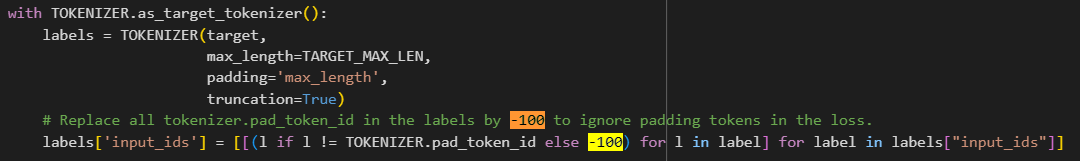

In [32]:
# also need to consider how to provide the decoder_input_ids
# correct the action vocabulary so that it can have initiall token-ids for <pad> <eos> etc.
# also to the target action_output add <eoa> (end of action) as the final token and stop the output

In [37]:
teach_model = MultimodalTEAChModelForActionGeneration(config=bart_config, util_config=config)

In [38]:
teach_model.to("cuda" if torch.cuda.is_available() else "cpu")

MultimodalTEAChModelForActionGeneration(
  (model): MultimodalTEAChModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (shared_action_embed): Embedding(19, 1024, padding_idx=0)
    (encoder): MultimodalBartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_action_tokens): Embedding(19, 1024, padding_idx=0)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linea

In [39]:
outputs = teach_model(
    input_ids=input_ids,
    attention_mask=attention_mask,
    action_input=action_input,
    visual_input=visual_input,
    decoder_visual_input=decoder_visual_input,
    labels=labels,
)

tensor([[ 1.2548, -1.2251,  0.5783,  ...,  0.6186, -0.4218, -0.2350],
        [ 0.5794, -1.0559,  0.4120,  ...,  0.8792, -0.5495,  0.2840],
        [ 0.1059, -1.3615,  0.0887,  ...,  0.1632, -0.4649,  0.3318],
        ...,
        [-0.4314, -0.4185, -0.6107,  ...,  1.1773,  0.2687, -0.3284],
        [-0.8682, -0.6672, -0.7186,  ...,  0.6177,  0.2013,  0.0569],
        [-0.5996, -1.0394, -0.6842,  ...,  0.9173,  0.0211,  0.1168]],
       device='cuda:0', grad_fn=<ViewBackward0>)
-----------------------
tensor([  11., -100., -100.,  ..., -100., -100., -100.], device='cuda:0')


In [48]:
outputs[0]

tensor(2.7808, device='cuda:0', grad_fn=<NllLossBackward0>)